### **Setup**

In [1]:
%%bash
pip install timm -q

### **Library Imports**

In [2]:
import os
import re
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### **Helpers**

In [3]:
SEED = 42
SIZE = 512

def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")

    
def get_image(path: str, size: int=224) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    return cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)


def show_loss_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()

    
def show_accuracy_graphs(A: list) -> None:
    TA, VA = [], []
    for i in range(len(A)):
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TA) + 1)
    plt.figure()
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

    
def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()

### **Configuration**

In [4]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 size: int = 224,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        self.seed = seed
        self.size = size
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.48231, 0.48231, 0.48231],
                                                     [0.22267, 0.22267, 0.22267]),
                                ])
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(seed=SEED, size=SIZE)

### **Dataset Template**

In [5]:
class DS(Dataset):
    def __init__(self, 
                 filenames: np.ndarray,
                 labels: np.ndarray,
                 size: int,
                 transform=None
                ):
        
        self.filenames = filenames
        self.labels = labels
        self.size = size
        self.transform = transform
    
    def __len__(self):
        return self.filenames.shape[0]

    def __getitem__(self, idx):
        image = get_image(self.filenames[idx], self.size)
        if self.labels is not None:
            return self.transform(image), torch.FloatTensor(self.labels[idx])
        else:
            return self.transform(image)

### **Model**

In [6]:
class Model(nn.Module):
    def __init__(self, model_name: str="resnet50"):
        super(Model, self).__init__()

        if model_name == "resnet34":
            self.model = models.resnet34(pretrained=True, progress=False)
            self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=1)
        
        elif model_name == "resnet50":
            self.model = models.resnet50(pretrained=True, progress=False)
            self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=1)
        
        elif model_name == "tv_resnet50":
            self.model = timm.create_model(model_name=model_name, pretrained=True)
            self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=1)

        elif model_name == "densenet169":
            self.model = models.densenet169(pretrained=True, progress=True)
            self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=1)

        elif model_name == "densenet201":
            self.model = models.densenet201(pretrained=True, progress=True)
            self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=1)
            
        elif model_name == "tv_densenet121":
            self.model = timm.create_model(model_name=model_name, pretrained=True)
            self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=1)
        
        elif model_name == "efficientnet_b0":
            self.model = timm.create_model(model_name=model_name, pretrained=True)
            self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=1)
        
        elif model_name == "efficientnet_b2":
            self.model = timm.create_model(model_name=model_name, pretrained=True)
            self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=1)
        
        else:
            raise NotImplementedError("Invalid Model Name. Model not currently available")
            
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False

    def forward(self, x):
        return self.model(x)

### **Fit**

In [7]:
def fit(model=None,
        model_name=None,
        optimizer=None, 
        scheduler_rlrop=None,
        scheduler_oclr=None,
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        save_path=None,
        device=None,
        verbose=False) -> tuple:
    
    if verbose:
        breaker()
        print(f" ----- {model_name.upper()} -----")
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
    
    bestLoss: dict = {"train" : np.inf, "valid" : np.inf} 
    
    Losses: list = []
    LRs: list = []
        
    if fold: 
        name = f"{model_name}_ble_state_fold_{fold}.pt"
    else: 
        name = f"{model_name}_ble_state.pt"
        
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss: dict = {"train" : 0.0, "valid" : 0.0} 

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass: list = []
            
            for X, y in dataloaders[phase]:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.MSELoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
        Losses.append(epochLoss)
        
        if scheduler_oclr:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
        elif scheduler_rlrop:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
        else:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict()}
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict,os.path.join(save_path, name))
        
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
            
    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, LRs, BLE, name

### **Train**

In [8]:
tr_df = pd.read_csv("../input/cxr-dataframe/train.csv")

filenames = tr_df.filenames.copy().values
labels = tr_df.label.copy().values

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth



**************************************************

 ----- RESNET34 -----

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.08867 | Valid Loss: 0.02167 | Time: 255.57 seconds
Epoch: 2 | Train Loss: 0.01798 | Valid Loss: 0.01039 | Time: 207.50 seconds

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [2 Epochs] : 7.72 minutes

**************************************************



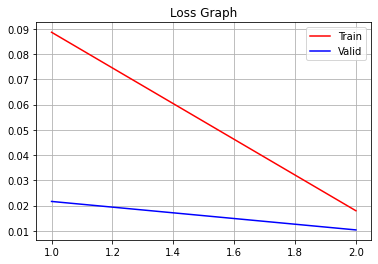


**************************************************



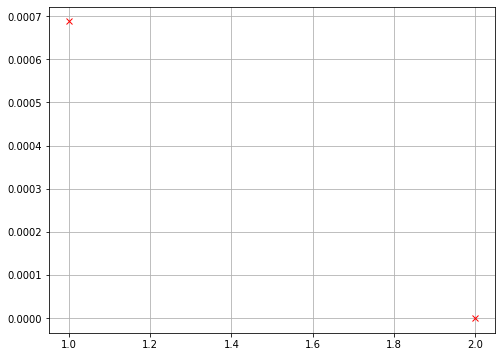


**************************************************



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth



**************************************************

 ----- RESNET50 -----

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.08088 | Valid Loss: 0.03485 | Time: 266.47 seconds
Epoch: 2 | Train Loss: 0.02144 | Valid Loss: 0.01331 | Time: 266.43 seconds

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [2 Epochs] : 8.88 minutes

**************************************************



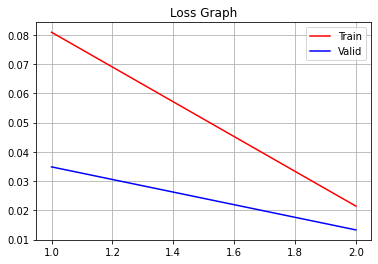


**************************************************



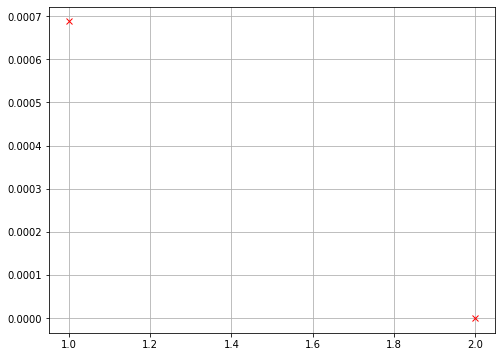


**************************************************



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



**************************************************

 ----- TV_RESNET50 -----

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.07956 | Valid Loss: 0.02882 | Time: 265.61 seconds
Epoch: 2 | Train Loss: 0.02035 | Valid Loss: 0.01332 | Time: 266.52 seconds

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [2 Epochs] : 8.87 minutes

**************************************************



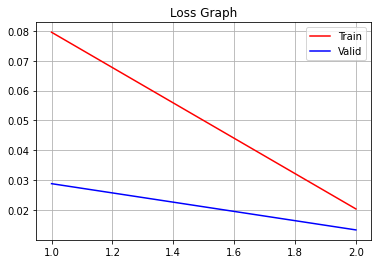


**************************************************



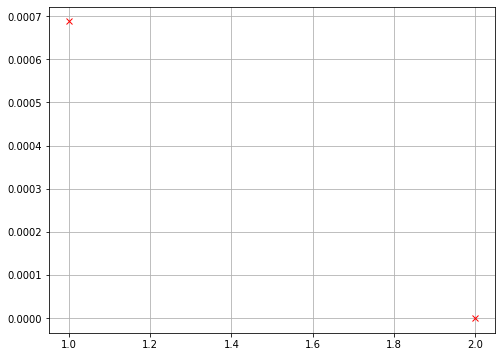


**************************************************



Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]


**************************************************

 ----- DENSENET169 -----

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.07494 | Valid Loss: 0.14873 | Time: 308.42 seconds
Epoch: 2 | Train Loss: 0.02279 | Valid Loss: 0.00853 | Time: 309.71 seconds

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [2 Epochs] : 10.30 minutes

**************************************************



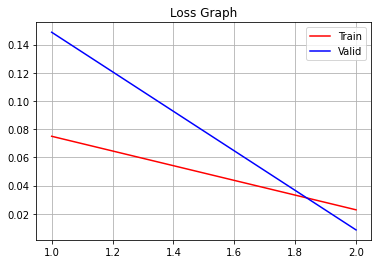


**************************************************



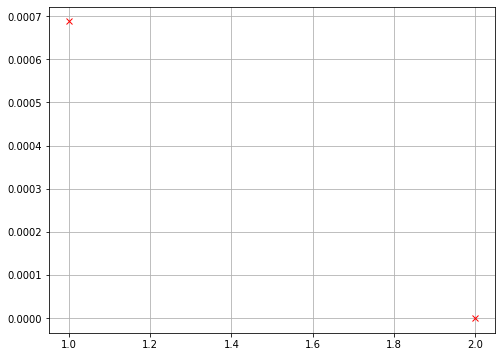


**************************************************



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



**************************************************

 ----- TV_DENSENET121 -----

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.12441 | Valid Loss: 0.02047 | Time: 277.77 seconds
Epoch: 2 | Train Loss: 0.02500 | Valid Loss: 0.00925 | Time: 276.15 seconds

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [2 Epochs] : 9.23 minutes

**************************************************



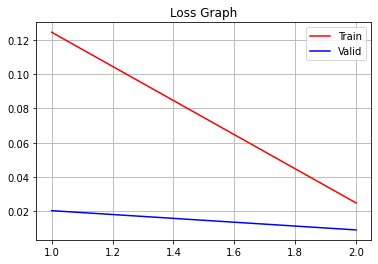


**************************************************



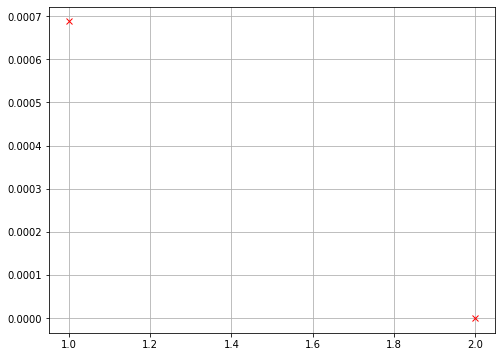


**************************************************



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth



**************************************************

 ----- EFFICIENTNET_B0 -----

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.10289 | Valid Loss: 0.01759 | Time: 217.31 seconds
Epoch: 2 | Train Loss: 0.00911 | Valid Loss: 0.00537 | Time: 216.76 seconds

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [2 Epochs] : 7.23 minutes

**************************************************



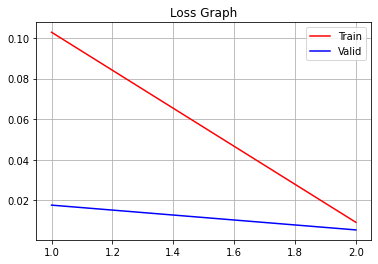


**************************************************



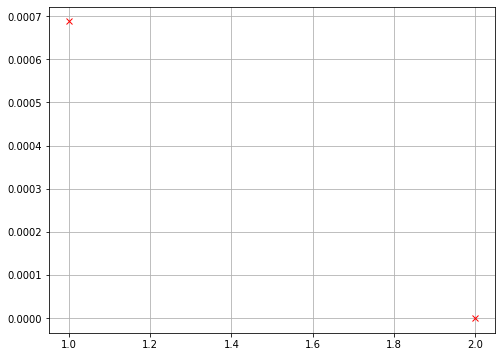


**************************************************



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth



**************************************************

 ----- EFFICIENTNET_B2 -----

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.11663 | Valid Loss: 0.01653 | Time: 254.18 seconds
Epoch: 2 | Train Loss: 0.00677 | Valid Loss: 0.00452 | Time: 252.64 seconds

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [2 Epochs] : 8.45 minutes

**************************************************



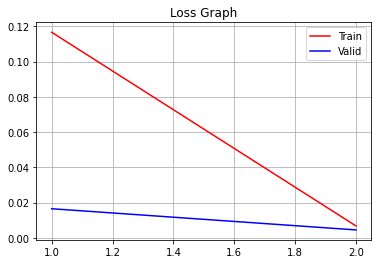


**************************************************



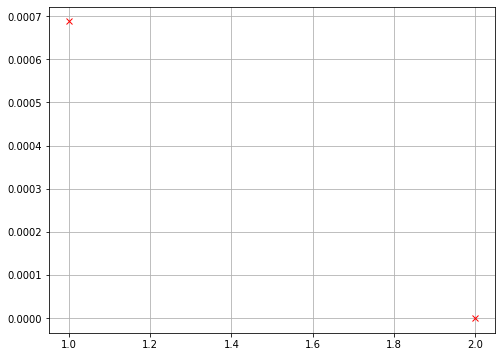


**************************************************



In [9]:
fold: int = 1
BLEs: list = []
BAEs: list = []
model_names: list = [
    "resnet34",
    "resnet50",
    "tv_resnet50",
    "densenet169",
    "tv_densenet121",
    "efficientnet_b0",
    "efficientnet_b2"
]
    
for tr_idx, va_idx in KFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(filenames):
    break

tr_filenames, va_filenames = filenames[tr_idx], filenames[va_idx] 
tr_labels, va_labels       = labels[tr_idx], labels[va_idx]

tr_data_setup = DS(
    filenames=tr_filenames, 
    labels=tr_labels.reshape(-1, 1),
    size=cfg.size,
    transform=cfg.transform
)

va_data_setup = DS(
    filenames=va_filenames,
    labels=va_labels.reshape(-1, 1),
    size=cfg.size,
    transform=cfg.transform
)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
}

cfg = CFG(
    epochs=2, 
    batch_size=64, 
    lr=1e-3,
    wd=0.0,
    early_stopping=5,
    steps_per_epoch=len(dataloaders["train"])
)

for model_name in model_names:
    torch.manual_seed(cfg.seed)
    model = Model(model_name=model_name).to(cfg.device)

    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd, momentum=0.9)
    
    scheduler_oclr = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer, 
        max_lr=cfg.max_lr, 
        epochs=cfg.epochs, 
        steps_per_epoch=cfg.steps_per_epoch,
        pct_start=cfg.pct_start, 
        div_factor=cfg.div_factor, 
        final_div_factor=cfg.final_div_factor
    )

    # scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer=optimizer,
    #     patience=cfg.patience,
    #     eps=cfg.eps,
    #     verbose=True
    # )
    
    # scheduler_oclr = None
    scheduler_rlrop = None


    L, LR, BLE, _ = fit(
        model=model, 
        model_name=model_name,
        optimizer=optimizer, 
        scheduler_oclr=scheduler_oclr,
        scheduler_rlrop=scheduler_rlrop,
        epochs=cfg.epochs, 
        early_stopping_patience=cfg.early_stopping, 
        dataloaders=dataloaders, 
        device=cfg.device,
        save_path=cfg.save_path,
        fold=None,
        verbose=True
    )
    
    breaker()
    show_loss_graphs(L)
    breaker()
    if scheduler_oclr:
        show_lr_graph(LR)
        breaker()
    
    BLEs.append(BLE)

### **Test Set Evalutaion**

In [10]:
def get_scores(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    return mean_absolute_error(y_true, y_pred), \
           mean_squared_error(y_true, y_pred), \
           r2_score(y_true, y_pred)


def print_scores(
    mae: float, 
    mse: float, 
    r2: float
) -> None:
    print(f"MAE : {mae:.5f}")
    print(f"MSE : {mse:.5f}")
    print(f"R2  : {r2}")



def predict_batch(model=None, dataloader=None, path=None, device=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    y_pred = torch.zeros(1, 1).to(device)
    for X in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = model(X)
        y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy().astype("uint8")

In [11]:
ts_df = pd.read_csv("../input/cxr-dataframe/train.csv")

ts_filenames = ts_df.filenames.copy().values
ts_labels = ts_df.label.copy().values

In [12]:
ts_data_setup = DS(
    filenames=ts_filenames,
    labels=None,
    size=cfg.size,
    transform=cfg.transform
)
ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

breaker()
for model_name in model_names:
    model = Model(model_name=model_name).to(cfg.device)
    
    model_path = f"saves/{model_name}_ble_state.pt"

    y_pred = predict_batch(
        model=model, 
        dataloader=ts_data, 
        path=model_path, 
        device=cfg.device
    )
    
    mae, mse, r2 = get_scores(ts_labels, y_pred)
    print(f"{model_name.upper()}\n")
    print_scores(mae, mse, r2)
    breaker()


**************************************************

RESNET34

MAE : 0.23452
MSE : 0.23452
R2  : -0.22555542807245366

**************************************************

RESNET50

MAE : 0.22381
MSE : 0.22381
R2  : -0.1696213580055772

**************************************************

TV_RESNET50

MAE : 0.15692
MSE : 0.15692
R2  : 0.17996657991240061

**************************************************

DENSENET169

MAE : 0.15233
MSE : 0.15233
R2  : 0.20393832422677616

**************************************************

TV_DENSENET121

MAE : 0.17278
MSE : 0.17278
R2  : 0.09706429749185153

**************************************************

EFFICIENTNET_B0

MAE : 0.74216
MSE : 0.74216
R2  : -2.8784284655300225

**************************************************

EFFICIENTNET_B2

MAE : 0.74216
MSE : 0.74216
R2  : -2.8784284655300225

**************************************************

